### Simple COVID-19 stochastic model based on Anderson et al. (_Lancet 2020_)

Below I define a stochastic version of the model defined diagrammatically below taken from Anderson et al. (_Lancet 2020_), linked here: https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30567-5/fulltext.

<img src="diagram-from-Anderson2020.png" width="600"/>

Note that in the epidemology of an SEIR model, the formalism usually indicates that, in this case, $\lambda = \beta I_1$. First the following imports are necessary...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Then the model parameters (all in units of 1/day) and initial compartment numbers must be defined...

In [15]:
bet, sig, gam1, gam2, gam3, alph, p = 1.0/4.0, 1.0/5.0, 1.0/5.0, 1.0/4.0, 1.0/4.0, 1.0/4.0, 0.1
S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R = 9500, 0, 500, 0, 0, 0, 0, 0, 0, 0

Finally, the number of realisations and the number of days to run must be chosen...

In [16]:
nreals = 100
ndays = 100

The model is coded in the following function...

In [17]:
# Package parameters and initial conditions all together
params = [bet, sig, gam1, gam2, gam3, alph, p]
initconds = [S*np.ones(nreals),E*np.ones(nreals), I1*np.ones(nreals), I2mild*np.ones(nreals),\
             I2severe*np.ones(nreals), I3mild*np.ones(nreals), I3severe*np.ones(nreals), Y2*np.ones(nreals),\
             Y3*np.ones(nreals), R*np.ones(nreals)]
# Define model function to output after specified time period
def covid_simple(initconds,params,reals,runtime,output_to_file): 
    # Open storage for output to file
    f = open(output_to_file, "w")
    # Unpack parameters and initial conditions
    [bet, sig, gam1, gam2, gam3, alph, p] = params
    [S, E, I1, I2mild, I2severe, I3mild, I3severe, Y2, Y3, R] = initconds 
    # Convert to float because I'm like that...
    runtime = float(runtime)   
    # Main loop
    t = np.zeros(reals)
    terminated = np.ones(reals)
    while np.any(t) < runtime:    
        # Terminate loop if everyone has recovered
        if np.all(S+E+I1+I2mild+I2severe+I3mild+I3severe+Y2+Y3) == 0: break
        # Update the event rates
        rate_S_E, rate_E_I1, rate_I1_I2, rate_I2severe_Y2 = bet*I1*S, sig*E, gam1*I1, alph*I2severe
        rate_I2mild_I3mild, rate_I2severe_I3severe, rate_Y2_Y3 = gam2*I2mild, gam2*I2severe, gam2*Y2
        rate_I3mild_R, rate_I3severe_R, rate_Y3_R = gam3*I3mild, gam3*I3severe, gam3*Y3       
        # Sum the rates
        rate_sum = rate_S_E + rate_E_I1 + rate_I1_I2 + rate_I2severe_Y2 + rate_I2mild_I3mild + \
                   rate_I2severe_I3severe + rate_Y2_Y3 + rate_I3mild_R + rate_I3severe_R + rate_Y3_R
        # Avoid pathologies at the end
        rate_sum[rate_sum<=0.0] = 1.0
        # Take step forward in time and determine when to stop each run
        t = t + terminated*np.random.exponential(1.0/rate_sum,size=reals) 
        terminated = (t<runtime)
        # Choose the event to occur in each realisation
        severe = np.random.binomial(1,p,size=reals)
        event = np.random.uniform(size=reals)
        event_probs = np.asarray([rate_S_E/rate_sum,rate_E_I1/rate_sum,\
                                  rate_I1_I2/rate_sum,rate_I2severe_Y2/rate_sum,rate_I2mild_I3mild/rate_sum,\
                                  rate_I2severe_I3severe/rate_sum,rate_Y2_Y3/rate_sum,rate_I3mild_R/rate_sum,\
                                  rate_I3severe_R/rate_sum,rate_Y3_R/rate_sum])
        cumul_probs = np.cumsum(event_probs,axis=0)
        # S -> E
        S = S - terminated*(event<cumul_probs[0])
        # S -> E, E -> I1
        E = E + terminated*(event<cumul_probs[0]) - terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0])
        # E -> I1, I1 -> I2
        I1 = I1 + terminated*(cumul_probs[1]>event)*(event>=cumul_probs[0]) \
                - terminated*(cumul_probs[2]>event)*(event>=cumul_probs[1])
        # I1 -> I2mild, I2mild -> I3mild
        I2mild = I2mild + terminated*(severe==0)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                        - terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3])
        # I1 -> I2severe, I2severe -> Y2, I2severe -> I3severe
        I2severe = I2severe + terminated*(severe==1)*(cumul_probs[2]>event)*(event>=cumul_probs[1]) \
                            - terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                            - terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4])
        # I2mild -> I3mild, I3mild -> R
        I3mild = I3mild + terminated*(cumul_probs[4]>event)*(event>=cumul_probs[3]) \
                        - terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6])
        # I2severe -> I3severe, I3severe -> R
        I3severe = I3severe + terminated*(cumul_probs[5]>event)*(event>=cumul_probs[4]) \
                            - terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7])
        # I2severe -> Y2, Y2 -> Y3
        Y2 = Y2 + terminated*(cumul_probs[3]>event)*(event>=cumul_probs[2]) \
                - terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5])
        # Y2 -> Y3, Y3 -> R
        Y3 = Y3 + terminated*(cumul_probs[6]>event)*(event>=cumul_probs[5]) \
                - terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # I3mild -> R, I3severe -> R, Y3 -> R
        R = R + terminated*(cumul_probs[7]>event)*(event>=cumul_probs[6]) \
              + terminated*(cumul_probs[8]>event)*(event>=cumul_probs[7]) \
              + terminated*(cumul_probs[9]>event)*(event>=cumul_probs[8])
        # Store values in file
        f.write(','.join(map(str,np.concatenate([t, S, E, I1, I2mild, I2severe, \
                                                 I3mild, I3severe, Y2, Y3, R]).ravel().tolist()))+'\n')
        f.flush()
    # Close file
    f.close()
    # Setup output column name list
    column_names = []
    for l in ['t', 'S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R']:
        for r in range(0,nreals):
            column_names.append(l+'_'+str(r))
    # Load dataframe with column names
    df = pd.read_csv(output_to_file,names=column_names)
    # Create dictionary of sub dataframes from output for each time series realisation
    dict_of_dfs = {}
    for r in range(0,nreals):
        dict_of_dfs['real_'+str(r)] = df[['t_'+str(r), 'S_'+str(r), 'E_'+str(r), 'Ii_'+str(r),\
                                          'Iiimild_'+str(r), 'Iiisevere_'+str(r), 'Iiiimild_'+str(r),\
                                          'Iiiisevere_'+str(r), 'Yii_'+str(r), 'Yiii_'+str(r), 'R_'+str(r)]]
        # Strip the time column of its number for merging
        dict_of_dfs['real_'+str(r)].columns = dict_of_dfs['real_'+str(r)].columns.str.rstrip('_'+str(r))
    # Output resulting compartment numbers to a dictionary of pandas dataframes
    return dict_of_dfs

Let's run the code and create a time-merged dataframe with all of the realisations and compartments as columns...

In [18]:
# Run code and obtain dictionary of dataframes output
ddf = covid_simple(initconds,params,nreals,ndays,'plot_data/test.csv')
# Map all column names onto their realisation numbers (apart from time) to avoid merge clashes
merged_df = ddf['real_0']
merged_df.columns = merged_df.columns.map(lambda c: c+'_0' if c!='t' else c)
for r in range(1,nreals):
    ddf['real_'+str(r)].columns = ddf['real_'+str(r)].columns.map(lambda c: c+'_'+str(r) if c!='t' else c)
    merged_df = pd.merge_asof(merged_df,ddf['real_'+str(r)],on='t')
# Set index to time
merged_df = merged_df.set_index('t')
merged_df

,S_0,E_0,Ii_0,Iiimild_0,Iiisevere_0,Iiiimild_0,Iiiisevere_0,Yii_0,Yiii_0,R_0,...,S_99,E_99,Ii_99,Iiimild_99,Iiisevere_99,Iiiimild_99,Iiiisevere_99,Yii_99,Yiii_99,R_99
t,,,,,,,,,,,,,,,,,,,,,
6.528963e-08,9499.0,1.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.110584e-07,9498.0,2.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.407838e-06,9497.0,3.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9497.0,3.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.196976e-06,9496.0,4.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9496.0,4.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.572070e-06,9495.0,5.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9496.0,4.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.860420e+01,0.0,0.0,4.0,10.0,0.0,27.0,1.0,2.0,1.0,9955.0,...,0.0,2.0,4.0,10.0,1.0,36.0,2.0,1.0,0.0,9944.0
4.866581e+01,0.0,0.0,4.0,10.0,0.0,26.0,1.0,2.0,1.0,9956.0,...,0.0,2.0,4.0,10.0,1.0,35.0,2.0,1.0,0.0,9945.0
4.875133e+01,0.0,0.0,4.0,10.0,0.0,25.0,1.0,2.0,1.0,9957.0,...,0.0,1.0,5.0,10.0,1.0,33.0,2.0,1.0,0.0,9947.0


Let's first plot the mean and 95% credible region for each compartment...

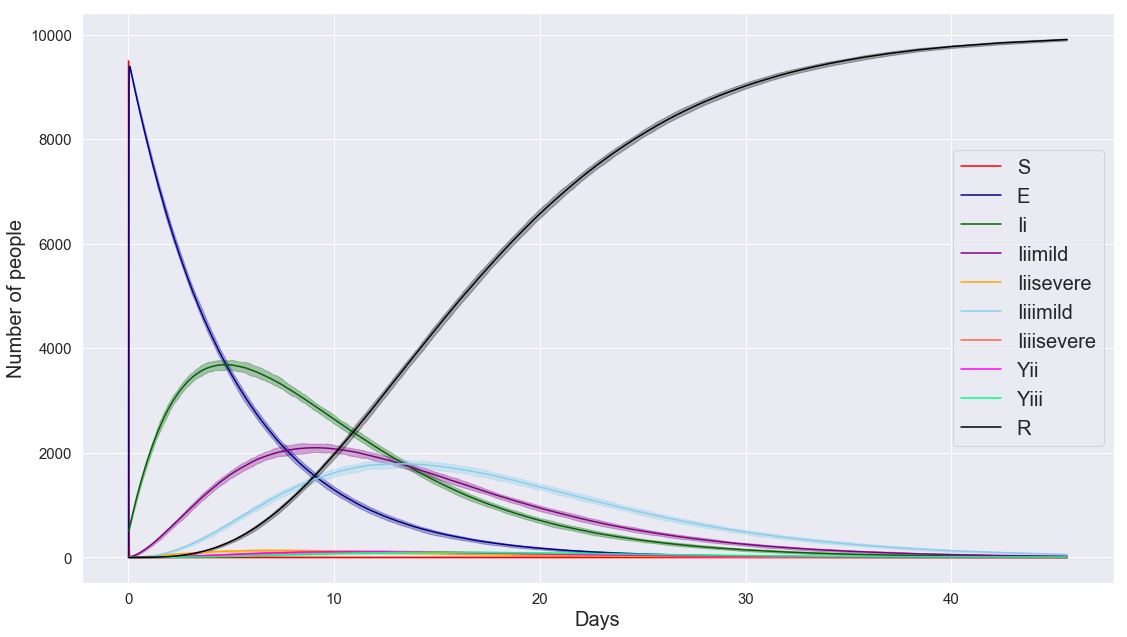

In [25]:
# The number of points to skip per value to make plotting faster
plot_every_n = 100
# Loop over all compartments of the model and plot on the same axes
for lab, col in zip(['S', 'E', 'Ii', 'Iiimild', 'Iiisevere', 'Iiiimild', 'Iiiisevere', 'Yii', 'Yiii', 'R'],
       ['red','darkblue','darkgreen','purple','orange','skyblue','tomato','magenta','springgreen','black']):
    # Compute mean and credible limits
    df = merged_df[[lab+'_'+str(r) for r in range(0,nreals)]]
    df_mean = df.iloc[::plot_every_n, :].mean(axis=1)
    df_lowerCL = df.iloc[::plot_every_n, :].quantile(0.025,axis=1)
    df_upperCL = df.iloc[::plot_every_n, :].quantile(0.975,axis=1)
    # Plot the mean and credible limits in each case
    plt.plot(merged_df.index[::plot_every_n],df_mean.values,color=col,label=lab)
    plt.fill_between(merged_df.index[::plot_every_n],df_lowerCL.values,df_upperCL.values,color=col,alpha=0.3)
# Name axes and rescale plot 
axes = plt.gca()
axes.set_ylabel('Number of people',fontsize=20)
axes.set_xlabel('Days',fontsize=20)
axes.tick_params(labelsize=15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(fontsize=20)
plt.show()